# Physical variable: land use

## 1.0 Introduction

The walkability index is composed of both physical and perception variables. The former represent the built environment available for walking along a street segment, while the latter reflect how the population perceives and assess the importance of the conditions of that segment. Our study considers six variables (population density, intersection density, land use mix, vegetation, slope, and sidewlaks), each with a physical and perception component. Each physical component must be geoprocessed in order to translate the input data into a characteristic that can be assigned to the street segments. This notebook describes the procedure required to transform the land use variable.

__Required input files:__

- __moravia_LH_edges_proj_net_initial.shp__ (Edges shapefile containing lines with attribute `osmid`)

- __moravia_LH_nodes_proj_net_initial.shp__ (Nodes shapefile; not used in processing, only for mapping/reference)

- __land_use_medellin.shp__ (Polygons shapefile containing `land_use` attribute)


## 2.0 Libraries

To interact with the database and process the various data, we have created a python script, `analysis.py`, which stores the different functions required for the task. In addition, other Python libraries are also used for data analysis and visualization.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.analysis as an

c:\Users\Sergio\anaconda3\envs\ox_eafit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3.0 Initial data

A mixture of land use activities surrounding a street segment typically indicates that more people will be willing to walk along that segment. Mixed land uses provide the population with opportunities to perform various activities within short distances, thereby increasing the street’s walkability. To capture this characteristic at the street-segment level, we start with the street network of one of our study areas and the land use distribution within each block, categorized as follows:

<div style="width: fit-content; margin: auto;">

| Category             | Description                                                  |
|----------------------|--------------------------------------------------------------|
| Residencial          | Housing areas                                                |
| Equipment            | Essential services like healthcare, education, or recreation |
| Commercial/Services  | Businesses and offices                                       |
| Industry             | Factories                                                    |
| Mix                  | Residential combined with another category                   |
| Complementary        | Activities supporting other categories                       |

</div>

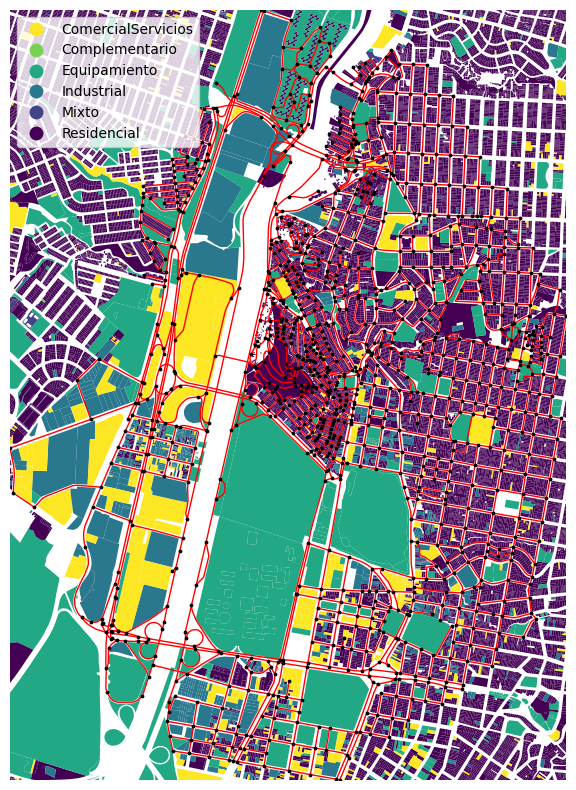

In [4]:
zone_edges = gpd.read_file('../data/output/shape/project_network_initial/moravia_LH/moravia_LH_edges_proj_net_initial.shp')
zone_nodes = gpd.read_file('../data/output/shape/project_network_initial/moravia_LH/moravia_LH_nodes_proj_net_initial.shp')
land_use = gpd.read_file('../data/input/shape/land_use/land_use_medellin.shp')
zone_edges = zone_edges.to_crs('epsg:32618')
zone_nodes = zone_nodes.to_crs('epsg:32618')
land_use = land_use.to_crs('epsg:32618')

# Definition of categories
categories = ['Residencial','Equipamiento','ComercialServicios','Industrial','Mixto','Complementario']
# Filter geodataframe
land_use = land_use[land_use['land_use'].isin(categories)]

# Graphic
minx, miny, maxx, maxy = zone_nodes.total_bounds
f, ax = plt.subplots(figsize=(20, 10))
land_use.plot(ax=ax, column='land_use',cmap='viridis_r' ,zorder=1, legend=True)
zone_nodes.plot(ax=ax, color='black', markersize=3, zorder=3)
zone_edges.plot(ax=ax, color='red', linewidth=1, zorder=2)
ax.set_axis_off()
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

## 4.0 Entropy calculation

In order to calculate the level of land use mixture surrounding each street segment, we defined a 20-meter buffer and applied an entropy index, defined as follows:
$$
\frac{1}{ln(n)}\sum^{n}_{k=1} \left[P_k * ln(P_k)\right]
$$
Where:
- $n$ represents the total number of categories (6).
- $k$ varies from every type of category.
- $P_k$ is the proportion of the buffer area accupied by a category $k$.

The entropy index ranges from 0 to 1, where 1 indicates a perfectly even distribution of land uses (maximum mixture), and 0 indicates no mixture (the buffer is occupied by a single land use category). This calculation is performed with the `calcular_entropia` function.

In [5]:
# Create a buffer around the street segments (e.g., 20 meters)
zone_edges = zone_edges.set_index('osmid')
zone_edges_buff = zone_edges.buffer(20, cap_style='flat')
zone_edges_buff = gpd.GeoDataFrame(index=zone_edges_buff.index, geometry=zone_edges_buff.geometry)
zone_edges_buff = zone_edges_buff.reset_index()

# Check which land use intersect with the edges
intersections = gpd.overlay(zone_edges_buff, land_use, how='intersection')

# Calculate the area of the intersections
intersections['area_inte'] = intersections.area

# Sum the intersection areas to get the total land use area
area_usos_edges = intersections.groupby('osmid')['area_inte'].sum()

# Group by land use category
land_use_presence_edges = intersections.groupby(['osmid', 'land_use'])['area_inte'].sum()

# Calculate the percentage of total area for each presence item (0 or 1)
percentage_land_use_edges = land_use_presence_edges / area_usos_edges

# Determine how many categories each osmid has
n_land_use = intersections.groupby(['osmid'])['land_use'].unique().apply(len)

# Create a series of all osmids present in zone_edges
all_osmid = zone_edges.index.to_series()

# Merge to add missing osmids
complete_n_land_use = all_osmid.to_frame(name='id').merge(
    n_land_use.rename('n'), how='left', left_index=True, right_index=True).drop(['id'], axis=1)

# Fill missing values with 0
complete_n_land_use['n'] = complete_n_land_use['n'].fillna(0).astype(int)

# Apply the entropy formula
zone_edges['entropy'] = zone_edges.index.map(
    lambda osmid: an.calcular_entropia(osmid, complete_n_land_use['n'], percentage_land_use_edges, categories))

zone_edges = zone_edges.rename(columns={'entropy':'land_use'})

## 5.0 Results



In [6]:
zone_edges.head()

,u,v,geometry,land_use
osmid,,,,
0,0,2,"LINESTRING (437449.345 692995.293, 437415.442 ...",0.329128
1,0,49,"LINESTRING (437449.345 692995.293, 437544.786 ...",0.386693
2,40,0,"LINESTRING (437501.818 693329.713, 437504.396 ...",0.000000
3,1,186,"LINESTRING (437370.198 692566.062, 437353.597 ...",0.318113
4,222,1,"LINESTRING (437389.463 692674.169, 437380.151 ...",0.700054


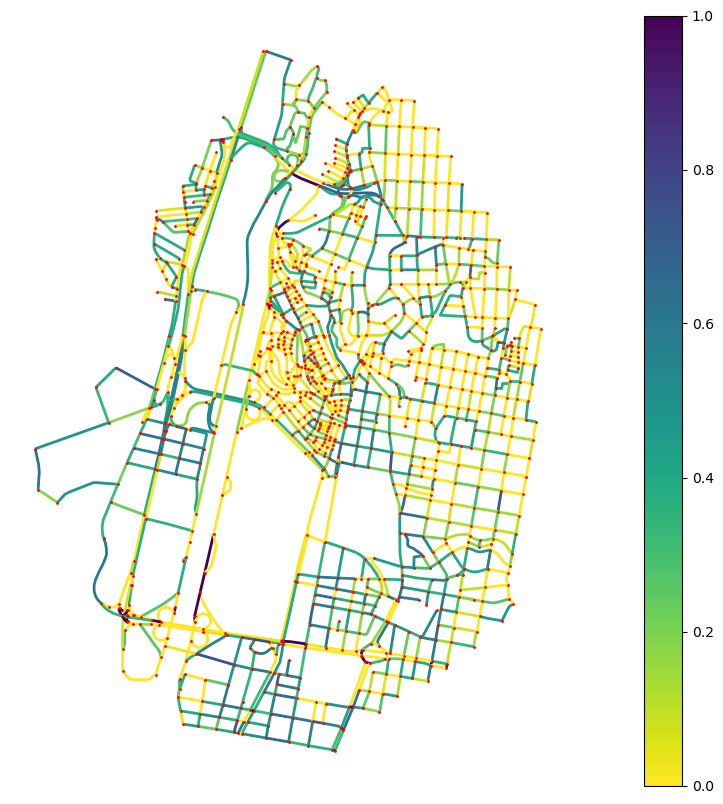

In [7]:
# Graphic
f, ax = plt.subplots(figsize=(20, 10))
zone_nodes.plot(ax=ax, color='red', markersize=1, zorder=3)
zone_edges.plot(ax=ax, column='land_use',cmap='viridis_r', linewidth=2, zorder=2, legend=True)
ax.set_axis_off()
plt.show()